# Plant Classification ft. CNN and Resnet50
* Data-feeding Strategy: 1 of below:
    1. Read all data at Once
    2. Use Data Generator and Augmentation
* Build Model: 1 of below:
    1. Regular CNN
    2. Resnet50

In [1]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import imgaug.augmenters as iaa
import imgaug as ia
import keras
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.
/Users/lenotsai/Desktop/0912_機器深度學習/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/lenotsai/Desktop/0912_機器深度學習/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/lenotsai/Desktop/0912_機器深度學習/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/U

**tqdm**
> Progress Bar
>
> https://github.com/tqdm/tqdm

In [2]:
# Read single image
data_path = './seed/*/*.png' 
img_paths = glob(data_path)
# img_paths = np.random.choice(img_paths, 50) # demo for 50 images

**Testing in below cells**

In [ ]:
# Testing: Show img
img = cv2.imread(img_paths[0])[:,:,::-1]  # Reverse RGB to BGR
print(img_paths[0])
plt.imshow(img)

In [ ]:
# Testing: Resize img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [ ]:
# Testing: Extract img class
img_path = img_paths[0]
img_path

In [ ]:
# Testing: Extract img class
cls = img_path.split('/')[-2]
cls

## Data-feeding Strategy: 1. Read all data at Once

In [3]:
IMG_SIZE = 128
BATCH_SIZE = 32
class_map = {'Charlock':0, 'Cleavers': 1, 'Fat Hen': 2, 'Maize': 3}

In [4]:
data_count = len(img_paths)
X = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ), dtype=int)
print(f'total images: {data_count}')

total images: 1373


In [5]:
for i, path in tqdm(enumerate(img_paths)):
    img = cv2.imread(path)[:,:,::-1]
    img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    cls = path.split('/')[-2]
    
    X[i] = img_resize
    y[i] = class_map[cls]

In [6]:
X = X/255
y_onehot = keras.utils.to_categorical(y, num_classes=4)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=5566)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1098, 128, 128, 3), (275, 128, 128, 3), (1098, 4), (275, 4))

In [8]:
# label count
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0: 390, 1: 287, 2: 475, 3: 221}

## Data-feeding Strategy: 2. Use Data Generator and Augmentation

In [ ]:
path_train, path_test = train_test_split(img_paths, test_size=0.2, random_state=5566)

In [ ]:
IMG_SIZE = 128
BATCH_SIZE = 32

In [ ]:
# imgaug 
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(-45, 45),
        mode=ia.ALL, # edge, reflect, symmetric, warp, constant
        shear=(-16,16)
    )
])

# Data Generator
def data_generator(data_paths, batch_size, aug:bool, preprocess=None):
    class_map = {'Charlock':0, 'Cleavers': 1, 'Fat Hen': 2, 'Maize': 3}
    '''data generator for fit_generator'''
    n = len(data_paths)
    i = 0
    data_paths = data_paths
    while True:
        image_data = []
        class_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(data_paths)
            path = data_paths[i]
            img = cv2.imread(path)[:,:,::-1]
            # img aug
            if aug:
                img = seq.augment_image(img)
            else:
                img = img / 255
            
            # img preprocess
            img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            if preprocess:
                img_resize = preprocess(img_resize)
            # read label
            cls = path.split('/')[-2]
            cls = class_map[cls]
            cls = to_categorical(cls, num_classes=len(class_map))

            image_data.append(img_resize)
            class_data.append(cls)
            i = (i+1) % n
        image_data = np.array(image_data)
        class_data = np.array(class_data)
        if preprocess:
            image_data = preprocess(image_data)
        yield image_data, class_data

**Data generation for Regular CNN**

In [ ]:
train_gen = data_generator(path_train, batch_size=BATCH_SIZE, aug=True)
test_gen = data_generator(path_test, batch_size=BATCH_SIZE, aug=False)

**Data generation for Resnet50**
with preprocess_input

In [ ]:
from keras.applications.resnet50 import preprocess_input
train_gen = data_generator(path_train, batch_size=BATCH_SIZE, aug=True, preprocess=preprocess_input)
test_gen = data_generator(path_test, batch_size=BATCH_SIZE, aug=False, preprocess=preprocess_input)

**Conv2D**
https://keras.io/layers/convolutional/#conv2d
```python
keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
# kernel_size=3 -> equals to (3, 3)
```
**MaxPool2D**
https://keras.io/layers/pooling/
```python
keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)
# pool_size=2 -> equals to (2, 2)
# strides=None -> default to pool_size
```
**Preprocess Input for Resnet50**
```python
from keras.applications.resnet50 import preprocess_input
```

## Build Model: 1. Regular CNN_MLP

In [ ]:
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = Conv2D(filters=16, kernel_size=3, activation='relu')(inputs)
x = Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = Conv2D(filters=16, kernel_size=3, activation='relu')(x)
x = MaxPool2D(2)(x)
x = Flatten()(x)
x = Dense(64, activation=keras.activations.relu)(x)
prediction = Dense(4, activation='softmax')(x)
model = Model(inputs=inputs, outputs=prediction, name='CNN_MLP')
model.summary()

## Build Model: 2. Resnet50

In [12]:
'''This cell is for MacOS user'''
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

* Automatically download Resnet50 model file
* model file: resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
* /Users/username/.keras/models/

In [14]:
# from keras.applications.resnet50 import preprocess_input
base_model = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3), )
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_map), activation='softmax')(x)
model = Model(base_model.input, predictions)

# freeze layers
# for layers in base_model.layers:
#     layers.trainable = False

#model.summary()

## callbacks & model.compile

In [15]:
# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint = ModelCheckpoint('./ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=False, save_best_only=False, period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

In [16]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

## Training
**1. train with all data**

In [17]:
logs = model.fit(X_train, y_train,
                batch_size=BATCH_SIZE,
                epochs=5,
                verbose=1,
                callbacks=[early_stopping, reduce_lr, checkpoint],     
                validation_data=(X_test, y_test))

Train on 1098 samples, validate on 275 samples
Epoch 1/5
1098/1098 [==============================] - 450s 410ms/step - loss: 1.6014 - acc: 0.5118 - val_loss: 1.8076 - val_acc: 0.5964
Epoch 2/5
1098/1098 [==============================] - 460s 419ms/step - loss: 0.6284 - acc: 0.7632 - val_loss: 4.6441 - val_acc: 0.5309
Epoch 3/5
1098/1098 [==============================] - 442s 403ms/step - loss: 0.4075 - acc: 0.8734 - val_loss: 0.7227 - val_acc: 0.8073
Epoch 4/5
1098/1098 [==============================] - 490s 446ms/step - loss: 0.2634 - acc: 0.9189 - val_loss: 1.0881 - val_acc: 0.7382
Epoch 5/5
1098/1098 [==============================] - 411s 374ms/step - loss: 0.2521 - acc: 0.9281 - val_loss: 13.6351 - val_acc: 0.1527


**2. train with data generator**

In [ ]:
logs = model.fit_generator(train_gen,
                           steps_per_epoch=np.ceil(len(path_train)/BATCH_SIZE),
                           epochs=5,
                           verbose=1,
                           callbacks=[early_stopping, reduce_lr,checkpoint],     
                           validation_data=test_gen,
                           validation_steps=np.ceil(len(path_test)/BATCH_SIZE),
                           )

## Analysis on loss & acc

In [18]:
history = logs.history
history

{'val_loss': [1.807597167708657,
  4.644099809473211,
  0.7227046856013212,
  1.0881236028671264,
  13.635087758844548],
 'val_acc': [0.5963636361468923,
  0.5309090906923467,
  0.8072727277062156,
  0.7381818175315857,
  0.15272727275436573],
 'loss': [1.6013763469859335,
  0.6284450246988098,
  0.4074947501249435,
  0.26344909064322436,
  0.25210230456892474],
 'acc': [0.5118397086695895,
  0.7632058287795993,
  0.8734061930783242,
  0.9189435338062015,
  0.9280510019300631],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001]}

Text(0.5, 1.0, 'acc')

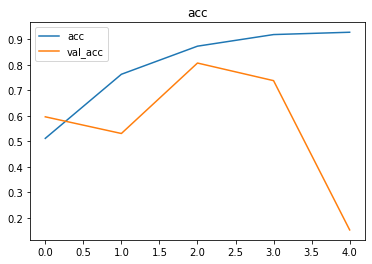

In [19]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

Text(0.5, 1.0, 'loss')

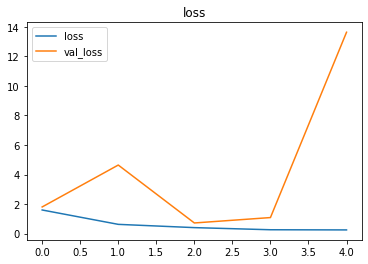

In [20]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

confusion_matrix for **1. train with all data**

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(y_true.shape, y_pred.shape)
target_names = [str(i) for i in range(4)]
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))


(275,) (275,)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        76
           1       0.00      0.00      0.00        64
           2       0.00      0.00      0.00        93
           3       0.15      1.00      0.26        42

    accuracy                           0.15       275
   macro avg       0.04      0.25      0.07       275
weighted avg       0.02      0.15      0.04       275

[[ 0  0  0 76]
 [ 0  0  0 64]
 [ 0  0  0 93]
 [ 0  0  0 42]]


/Users/lenotsai/Desktop/0912_機器深度學習/venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


confusion_matrix for **2. train with data generator**

In [ ]:
X_test, y_test = next(test_gen)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(X_test), axis=-1)
print(y_true.shape, y_pred.shape)
target_names = [str(i) for i in range(4)]
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))